In [17]:
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime
import pandas as pd
import numpy as np
import umap
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy import sparse

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karamov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def log(message):
    now = datetime.datetime.now()
    print("{0} - {1}".format(now.strftime("%Y-%m-%d %H:%M:%S"), message))
    return

In [19]:
class DocumentsNormalizer:
    def __init__(self, normalization_algorithm=None, token_len_min=0, should_log=False):
        self._stop_words = []
        self.__read_stop_words()
        self._token_len_min = token_len_min
        self.should_log = should_log

    def normalize_documents(self, docs):
        log('start normalization')
        html_free_docs = docs.apply(self.__extract_row_text_from_html)
        log('end extract tow text from html')
        punctuation_free_docs = html_free_docs.apply(self.__remove_punctuation)
        log('end of removing  punctuation ')
        tokens_collections = punctuation_free_docs.apply(lambda x: word_tokenize(x.lower()))
        log('end tokenize')
        a = self.__remove_noise(tokens_collections)
        log('end of removing noise')
        return a.apply(lambda _tokens: " ".join(_tokens))

    def __remove_noise(self, token_collections):
        return token_collections.apply(
            lambda collection: list(filter(
                lambda token: token not in self._stop_words and not token.isdigit() and len(
                    token) >= self._token_len_min,
                collection)))

    @staticmethod
    def __to_dict(tokens):
        unique_tokens = {}
        for token in tokens:
            if token in unique_tokens:
                unique_tokens[token] += 1
            else:
                unique_tokens[token] = 1
        return unique_tokens

    @staticmethod
    def __extract_row_text_from_html(text):
        soup = BeautifulSoup(text, 'html.parser')
        html_free = soup.get_text(strip=True, separator=' ')
        return html_free

    @staticmethod
    def __remove_punctuation(text):
        chars = []
        for char in text:
            if char in string.punctuation:
                chars.append(' ')
            else:
                chars.append(char)
        return "".join(chars)

    def __read_stop_words(self):
        english_stop_words = stopwords.words("english")
        with open('./ru_stop_words.txt', mode='r', encoding='utf-8') as f:
            raw_stop_words = f.readlines()
            for stop_word in raw_stop_words:
                self._stop_words.append(stop_word.strip())
        self._stop_words = self._stop_words + english_stop_words

def create_frequency_table(min_df=0.1, max_df=0.98):
    data_set = pd.read_csv('./merged.csv').head(10000)
    normalizer = DocumentsNormalizer(should_log=True)
    corpus = normalizer.normalize_documents(data_set['description'])
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, dtype=np.uint16)
    frequency_table = vectorizer.fit_transform(corpus)
    return vectorizer.get_feature_names(), frequency_table

def save_frequency_table(terms, frequency_table):
    sparse.save_npz('./frequency_table', frequency_table)
    with open('./terms', 'w', encoding='utf-8') as f:
        f.write('\n'.join(terms))

def build_frequency_table():
    terms, frequency_table = create_frequency_table(min_df=0.005, max_df=0.99)
    save_frequency_table(terms, frequency_table)

In [20]:
def create_frequency_table(min_df=0.1, max_df=0.98):
    data_set = pd.read_csv('./merged.csv')
    normalizer = DocumentsNormalizer(should_log=True)
    corpus = normalizer.normalize_documents(data_set['description'])
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, dtype=np.uint16)
    frequency_table = vectorizer.fit_transform(corpus)
    return vectorizer.get_feature_names(), frequency_table

def save_frequency_table(terms, frequency_table):
    sparse.save_npz('./frequency_table', frequency_table)
    with open('./terms', 'w', encoding='utf-8') as f:
        f.write('\n'.join(terms))

def build_frequency_table():
    terms, frequency_table = create_frequency_table(min_df=0.005, max_df=0.99)
    save_frequency_table(terms, frequency_table)

In [21]:
#create frequency_table and save to npz file  called once
#build_frequency_table()
#log('end build frequency_table')

2020-04-13 16:20:12 - start normalization
2020-04-13 16:21:25 - end extract tow text from html
2020-04-13 16:21:42 - end of removing  punctuation 
2020-04-13 16:22:44 - end tokenize
2020-04-13 16:23:51 - end of removing noise
2020-04-13 16:24:04 - end build frequency_table


In [27]:
#run this
def print_topics(count_related_words, components, terms):
    for i, comp in enumerate(components):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:count_related_words]
        topic = "Topic " + str(i) + ": "
        for sorted_term in sorted_terms:
            topic = topic + sorted_term[0] + ' '
        print(topic)

def read_frequency_table():
    frequency_table = sparse.load_npz('./frequency_table.npz')
    terms = []
    with open('./terms', 'r', encoding='utf-8') as f:
        data = f.readlines()
        for i in data:
            terms.append(i.strip())
    return frequency_table, terms

def mark_document_to_topic(row):
    return pd.Series(row).idxmax()


#Читаем таблицу частотности
frequency_table, terms = read_frequency_table()
print(frequency_table.shape)

#Выделяем 20 топиков с помощью SVD
svd_model = TruncatedSVD(n_components=20, n_iter=100)
topics = svd_model.fit_transform(frequency_table)
#Каждому документу присваеваем класс от 0 до 19. Класс соответствует max значению топика для документа. 
by_class = np.apply_along_axis(mark_document_to_topic, 1, topics)
#печатаем 10 важных слов слов для каждого топика
print_topics(10, svd_model.components_, terms)
log('end build svd')

#сжимаем в 2-мерное пространсто чтобы нарисовать
embedding = umap.UMAP(n_neighbors=50, min_dist=0.5).fit_transform(topics)
log('end embedding')


(57155, 4199)
Topic 0: опыт работы знание компании разработки работа требования условия систем умение 
Topic 1: 1с компании работа клиентов продаж бизнес обучение оформление условия работать 
Topic 2: experience team development work business skills knowledge management data working 
Topic 3: 1с знание систем опыт разработка разработки конфигураций пользователей предприятие процессов 
Topic 4: бизнес процессов разработки требований систем решений участие ит разработка проектов 
Topic 5: 1с разработки опыт возможность компании задачи работать команде приложений команда 
Topic 6: опыт бизнес ит процессов работы 1с контроль систем продаж управление 
Topic 7: компании систем данных безопасности возможность информационной технологий оборудования администрирование sql 
Topic 8: данных работы бизнес sql процессов анализ oracle data баз анализа 
Topic 9: опыт данных продаж работа компании клиентов sql обязанности условия требования 
Topic 10: знание бизнес процессов компании sap работы опыт пр

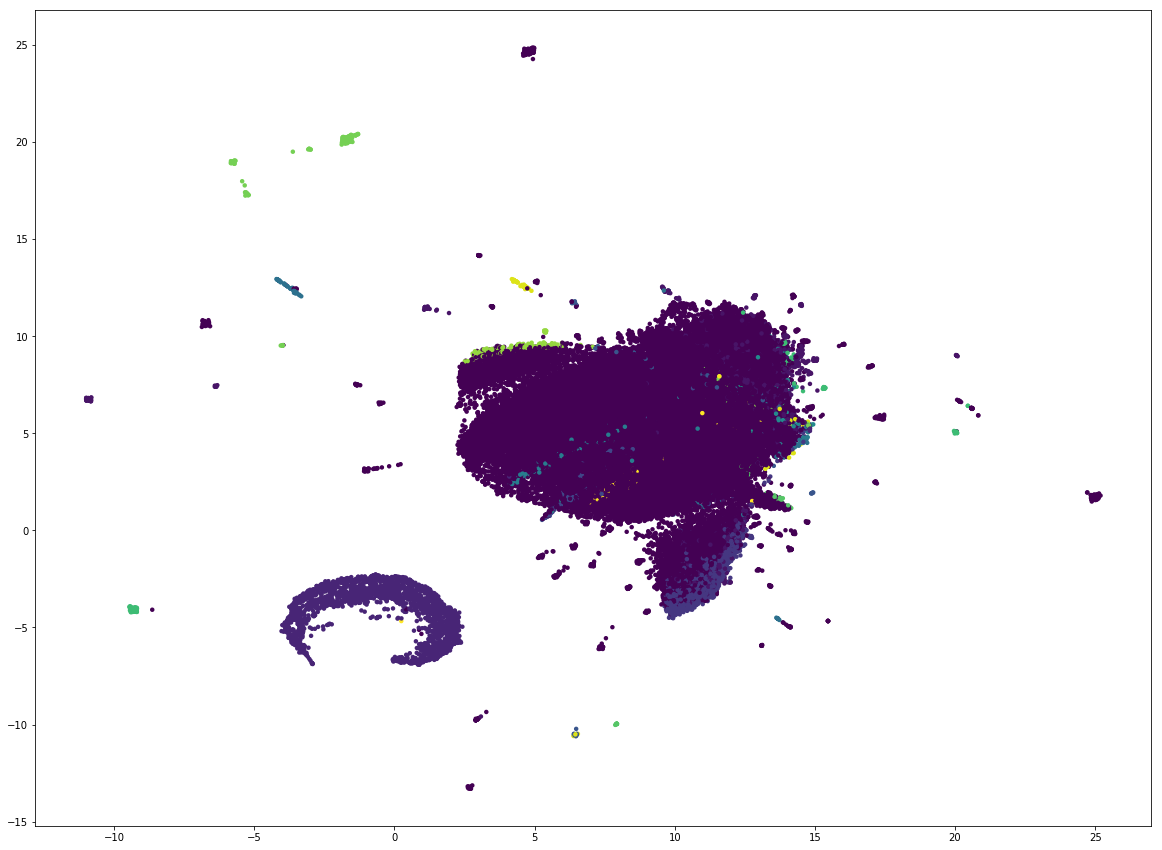

In [29]:
plt.figure(figsize=(20, 15))
plt.scatter(embedding[:, 0], embedding[:, 1],
            c=by_class,
            s=20,
            edgecolor='none')
plt.show()